# Recommender System with Collaborative Filtering

First, we need to read the data from the dataset.

In [47]:
import pandas as pd
import numpy as np

In [48]:
datasets_loc = "datasets"
# datasets_loc = "toy_datasets"

In [49]:
ratings = pd.read_csv(datasets_loc + "/ratings.csv", delim_whitespace=True, skiprows=1, names=["UserID", "ProfileID", "Rating"])
# gender = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender"]) (For large dataset)
info = pd.read_csv(datasets_loc + "/info.csv", names=["UserID", "Gender", "Name"])

Here is our data. UserID is the user, ProfileID is the profile that user is looking at.

In [50]:
ratings.head()

,UserID,ProfileID,Rating
0,1,133,8
1,1,720,6
2,1,971,10
3,1,1095,7
4,1,1616,10


In [51]:
info.head()

,UserID,Gender,Name
0,1,F,NaN
1,2,F,NaN
2,3,U,NaN
3,4,F,NaN
4,5,F,NaN


In [52]:
ratings = pd.merge(info, ratings)
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,8
1,1,F,NaN,720,6
2,1,F,NaN,971,10
3,1,F,NaN,1095,7
4,1,F,NaN,1616,10
...,...,...,...,...,...
17359341,135359,F,NaN,215145,8
17359342,135359,F,NaN,215718,4
17359343,135359,F,NaN,218646,10
17359344,135359,F,NaN,218857,7


We map the rating to like/ dislike. Rating smaller than 5 will consider as a dislike to the profile.

In [53]:
ratings["Rating"] = np.where(ratings["Rating"] < 5, 0, 1)
ratings = ratings[ratings["Rating"] == 1]
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,1
1,1,F,NaN,720,1
2,1,F,NaN,971,1
3,1,F,NaN,1095,1
4,1,F,NaN,1616,1
...,...,...,...,...,...
17359340,135359,F,NaN,214297,1
17359341,135359,F,NaN,215145,1
17359343,135359,F,NaN,218646,1
17359344,135359,F,NaN,218857,1


Due to large data set, we need to reduce the data records.

In [54]:
ratings = ratings[(ratings["UserID"] <= 10000) & (ratings["ProfileID"] <= 10000)]
ratings

,UserID,Gender,Name,ProfileID,Rating
0,1,F,NaN,133,1
1,1,F,NaN,720,1
2,1,F,NaN,971,1
3,1,F,NaN,1095,1
4,1,F,NaN,1616,1
...,...,...,...,...,...
1261990,9999,M,NaN,90,1
1261992,9999,M,NaN,9690,1
1262054,10000,F,NaN,3968,1
1262056,10000,F,NaN,7724,1


# Preparing data for Collaborative Filtering  

In [55]:
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

Data here only contains the user likes. Dislike rating and no rating will be considered as NaN.

In [56]:
user_ratings = ratings.pivot_table(index=["UserID"], columns=["ProfileID"], values=["Rating"])
user_ratings.head()

Rating                                                        ...  \
ProfileID  1     2     8     9     17    23    26    28    31    32     ...   
UserID                                                                  ...   
1            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
6            NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

                                                                       
ProfileID 9986  9987  9988  9989  9990  9995  9996  9997  9998  10000  
UserID                                                                 
1           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
6           NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 3607 columns]

So here, we fill all NaN to 0. Assuming if user did not vote -> dislike.
Which is not ideal.

In [57]:
user_ratings = user_ratings.fillna(0)
user_ratings

Rating                                                        ...  \
ProfileID  1     2     8     9     17    23    26    28    31    32     ...   
UserID                                                                  ...   
1            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
2            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
4            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
5            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
6            0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
...          ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
9995         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9996         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9998         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
9999         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   
10000        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...   

                                                                       
ProfileID 9986  9987  9988  9989  9990  9995  9996  9997  9998  10000  
UserID                                                                 
1           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
5           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
6           0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
...         ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
9995        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9996        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9998        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
9999        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
10000       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[8591 rows x 3607 columns]

In [58]:
# Clear pivot table structure to extra index and columns

user_ratings_df = user_ratings.copy()

user_ratings_df.columns = user_ratings.columns.droplevel(0)
user_ratings_df.name = None
user_ratings_df = user_ratings_df.reset_index()
user_ratings_df.index = user_ratings_df["UserID"]
user_ratings_df.index.name = "UserID"
user_ratings_df.drop("UserID", axis="columns", inplace=True)

user_ratings_df

ProfileID,1,2,8,9,17,23,26,28,31,32,...,9986,9987,9988,9989,9990,9995,9996,9997,9998,10000
UserID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Item-based Collaborative Filtering
With KNN algorithm, we can find the similar profiles to the profile that user is looking at. 

In [59]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(metric="cosine", algorithm="brute")
knn.fit(user_ratings_df.T)

# Here, skipped the cosine similarity matrix

# Same dataset (traning and testing), so nearest is itself (For now)
distances, indices = knn.kneighbors(user_ratings_df.T.values, n_neighbors=3)

In [60]:
# Predict like/ dislike for a Profile by a User

def findNearestProfiles(profile_id):
    # Get the index for a profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)

    # Find the indices for similar profiles
    sim_profiles = indices[index_of_profile].tolist()

    # Find the distances between the profile and similar profiles
    sim_profiles_distances = distances[index_of_profile].tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if index_of_profile in sim_profiles:
        # The position of the profile in the list of similar profiles
        index_of_profile_in_sim = sim_profiles.index(index_of_profile)

        # Remove the profile from the list of similar profiles
        sim_profiles.pop(index_of_profile_in_sim)

        # Remove the profile from the list of similar profiles distances
        sim_profiles_distances.pop(index_of_profile_in_sim)

    print("The nearest profiles to Profile {} are:".format(profile_id), ["Profile {}".format(user_ratings_df.columns[i]) for i in sim_profiles])
    print("The distance from Profile {}:".format(profile_id), sim_profiles_distances)
    print("Returned", sim_profiles, sim_profiles_distances)
    return sim_profiles, sim_profiles_distances

findNearestProfiles(1)

The nearest profiles to Profile 1 are: ['Profile 6359', 'Profile 2938']
The distance from Profile 1: [0.5917517095361369, 0.683772233983162]
Returned [2284, 1060] [0.5917517095361369, 0.683772233983162]


([2284, 1060], [0.5917517095361369, 0.683772233983162])

In [61]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the profile
    profile_ratings = user_ratings_df.T.iloc[index_of_profile].values.tolist()

    # Find the nearest neighbors of the profile
    sim_profiles, sim_profiles_distances = findNearestProfiles(profile_id)
    
    # Get the ratings for the similar profiles
    sim_profiles_ratings = [user_ratings_df.T.iloc[i].values.tolist() for i in sim_profiles]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_profiles_distances[i] * (sim_profiles_ratings[i][index_of_user] - average(user_ratings_df.T.iloc[sim_profiles[i]].values.tolist())) for i in range(len(sim_profiles))])
    denominator = sum(sim_profiles_distances)

    if denominator > 0:
        predicted_rating = average(profile_ratings) + numerator / denominator 
    else:
        predicted_rating = average(profile_ratings)

    print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(3, 11)

In [62]:
# Recommender system for a user
predicted_ratings = user_ratings_df.T.copy()

def recommender_system_item_based_CF(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        if user_ratings_df.T.loc[profile_id, user_id] == 0:
            predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
            recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [63]:
# Output recommendations
user_id = 1

recommendations = recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

The nearest profiles to Profile 1 are: ['Profile 6359', 'Profile 2938']
The distance from Profile 1: [0.5917517095361369, 0.683772233983162]
Returned [2284, 1060] [0.5917517095361369, 0.683772233983162]
The predicted rating for User 1 and Profile 1 is: -0.0008316012836826801
The nearest profiles to Profile 2 are: ['Profile 1015', 'Profile 469']
The distance from Profile 2: [0.6077677297236319, 0.6603168897566212]
Returned [365, 163] [0.6077677297236319, 0.6603168897566212]
The predicted rating for User 1 and Profile 2 is: 0.0010379607054445288
The nearest profiles to Profile 8 are: ['Profile 1640', 'Profile 3661']
The distance from Profile 8: [0.29289321881345254, 0.29289321881345254]
Returned [585, 1311] [0.29289321881345254, 0.29289321881345254]
The predicted rating for User 1 and Profile 8 is: -0.00011640088464672329
The nearest profiles to Profile 9 are: ['Profile 584', 'Profile 3321']
The distance from Profile 9: [0.42264973081037416, 0.42264973081037416]
Returned [205, 1192] [0.4

UserID,1,2,4,5,6,7,9,11,12,13,...,9990,9991,9992,9993,9994,9995,9996,9998,9999,10000
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,-0.000832,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.000116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.000510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.000116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.000116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [64]:

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User 1:
(9807, 0.9371058644084476)
(7006, 0.5600489554971433)
(4752, 0.541123229156675)
(7602, 0.5286703505593894)
(4937, 0.5133344290186219)
(3301, 0.5087229201347665)
(3539, 0.5076917815379518)
(4301, 0.5038340987619894)
(2746, 0.5016822458814473)
(2518, 0.49593251091639035)
(8918, 0.4945219304649539)
(483, 0.49438181416450533)
(5918, 0.4889821507219809)
(8177, 0.4844501236499205)
(6437, 0.4785085919483687)
(8208, 0.47175290692427513)
(7768, 0.4703616610209063)
(4156, 0.46500039118033404)
(6269, 0.4624366748476511)
(7774, 0.4396879230164235)
(8510, 0.4296567633921755)
(1429, 0.4263839736817225)
(6036, 0.08435171683202382)
(1721, 0.07489282436144748)
(9680, 0.045569614047306806)
(1561, 0.03727352368408396)
(328, 0.032794915516911834)
(6932, 0.028730921637594425)
(1029, 0.02442757412148246)
(394, 0.02095548889131613)
(215, 0.017992086175190016)
(2111, 0.017762441105384965)
(9759, 0.01734573337642924)
(7219, 0.017085349333967086)
(9855, 0.016830069383590954)
(30

# User-based Collaborative Filtering with Jaccard Similarity

In [37]:
import scipy.spatial

jaccard = scipy.spatial.distance.cdist(user_ratings_df, user_ratings_df, metric="jaccard")
sim_users_distance_df = pd.DataFrame(jaccard, index=user_ratings_df.index.values, columns=user_ratings_df.index.values)
sim_users_distance_df

,1,2,4,5,6,7,9,11,12,13,...,9990,9991,9992,9993,9994,9995,9996,9998,9999,10000
1,0.000000,0.954545,0.956522,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,0.950000,1.000000,1.0,1.0,1.0,0.909091,1.0,1.0,1.0,0.950
2,0.954545,0.000000,1.000000,1.0,1.0,1.000000,1.0,0.875,1.0,1.0,...,0.857143,1.000000,1.0,1.0,1.0,0.900000,1.0,1.0,1.0,1.000
4,0.956522,1.000000,0.000000,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.0,0.800000,1.0,1.0,1.0,0.875
5,1.000000,1.000000,1.000000,0.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,1.000000,0.571429,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000
6,1.000000,1.000000,1.000000,1.0,0.0,0.666667,1.0,1.000,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.909091,0.900000,0.800000,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,0.875000,1.000000,1.0,1.0,1.0,0.000000,0.9,1.0,1.0,0.875
9996,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.0,0.900000,0.0,1.0,1.0,1.000
9998,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,0.0,1.0,1.000
9999,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.0,1.000,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.0,1.0,0.0,1.000


In [38]:
# Find nearest users with Jaccard distance

def findNearestUsersWithJaccard(user_id):
    # Extract the sorted distance of its neighbours for a user
    sim_users_distances_series = sim_users_distance_df[user_id].nsmallest(3)
    sim_users = [i for i in sim_users_distances_series.index if i != user_id]
    sim_users_distances = sim_users_distances_series.values.tolist()

    # Case when the target profile is not in the list, multiple values are the same
    if user_id in sim_users:
        # The index of the user in the list of similar users
        index_of_user_in_sim = sim_users.index(user_id)

        # Remove the user from the list of similar users distances
        sim_users_distances.pop(index_of_user_in_sim)

    return sim_users, sim_users_distances

# findNearestUsersWithJaccard(3)

In [66]:
# Predict rating of a user and a profile
def average(lst): 
    return sum(lst) / len(lst)

def predict_rating_with_neighbor_correlations(user_id, profile_id):
    # Get the index of target user and profile
    index_of_profile = user_ratings_df.T.index.tolist().index(profile_id)
    index_of_user = user_ratings_df.index.tolist().index(user_id)

    # Get the ratings for the user
    user_ratings = user_ratings_df.iloc[index_of_user].values.tolist()

    # Find the nearest neighbors of the user
    sim_users, sim_users_distances = findNearestUsersWithJaccard(user_id)
    
    # Get the ratings for the similar users
    sim_users_ratings = [user_ratings_df.loc[i].values.tolist() for i in sim_users]
    
    # Predicted_rating calculaton from: https://towardsdatascience.com/comprehensive-guide-on-item-based-recommendation-systems-d67e40e2b75d
    numerator = sum([sim_users_distances[i] * (sim_users_ratings[i][index_of_profile] - average(user_ratings_df.loc[sim_users[i]].values.tolist())) for i in range(len(sim_users))])
    denominator = sum(sim_users_distances)

    predicted_rating = average(user_ratings) + numerator / denominator 

    print("Returned", sim_users, sim_users_distances)
    print("The predicted rating for User {}".format(user_id), "and Profile {} is:".format(profile_id), predicted_rating)

    return predicted_rating

# predict_rating_with_neighbor_correlations(3, 11)

In [67]:
# Recommender system for a user
predicted_ratings = user_ratings_df.T.copy()

def recommender_system_user_based_CF_Jaccard(user_id):
    recommendations = []

    for profile_id in predicted_ratings.index:

        # # TODO: Knowing whether the user has viewed the profile or not
        if user_ratings_df.T.loc[profile_id, user_id] == 0:
            predicted_ratings.loc[profile_id, user_id] = predict_rating_with_neighbor_correlations(user_id, profile_id)
            recommendations.append((profile_id, predicted_ratings.loc[profile_id, user_id]))
    
    return recommendations

In [68]:
# Output recommendations
user_id = 1

recommendations = recommender_system_item_based_CF(user_id)
pd.DataFrame(predicted_ratings)

Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 1 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 2 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 8 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 9 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 17 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 23 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.7692307692307693, 0.7894736842105263]
The predicted rating for User 1 and Profile 26 is: 0.004306201145679938
Returned [4664, 599] [0.0, 0.76

UserID,1,2,4,5,6,7,9,11,12,13,...,9990,9991,9992,9993,9994,9995,9996,9998,9999,10000
ProfileID,,,,,,,,,,,,,,,,,,,,,
1,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.004306,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:

if datasets_loc == "datasets":
    print("Recommended profiles for User {}:".format(user_id))
else:
    print("Recommended profiles for User {}:".format(info.loc[info["UserID"] == user_id, "Name"].values[0]))

for profile_id, predicted_rating in sorted(recommendations, key=lambda x: x[1], reverse=True):
    if datasets_loc == "datasets":
        print((profile_id, predicted_rating)) 
    else:
        print((info.loc[info["UserID"] == profile_id, "Name"].values[0], predicted_rating)) 

Recommended profiles for User 1:
(5673, 0.4978126946521734)
(1, 0.004306201145679938)
(2, 0.004306201145679938)
(8, 0.004306201145679938)
(9, 0.004306201145679938)
(17, 0.004306201145679938)
(23, 0.004306201145679938)
(26, 0.004306201145679938)
(28, 0.004306201145679938)
(31, 0.004306201145679938)
(32, 0.004306201145679938)
(34, 0.004306201145679938)
(36, 0.004306201145679938)
(38, 0.004306201145679938)
(41, 0.004306201145679938)
(42, 0.004306201145679938)
(46, 0.004306201145679938)
(47, 0.004306201145679938)
(49, 0.004306201145679938)
(50, 0.004306201145679938)
(51, 0.004306201145679938)
(55, 0.004306201145679938)
(57, 0.004306201145679938)
(58, 0.004306201145679938)
(61, 0.004306201145679938)
(63, 0.004306201145679938)
(68, 0.004306201145679938)
(71, 0.004306201145679938)
(73, 0.004306201145679938)
(74, 0.004306201145679938)
(76, 0.004306201145679938)
(77, 0.004306201145679938)
(84, 0.004306201145679938)
(88, 0.004306201145679938)
(90, 0.004306201145679938)
(91, 0.004306201145679938)

# Visualize the network graph

Using the non pivot version (ratings) to visualize.

## For small dataset visualization

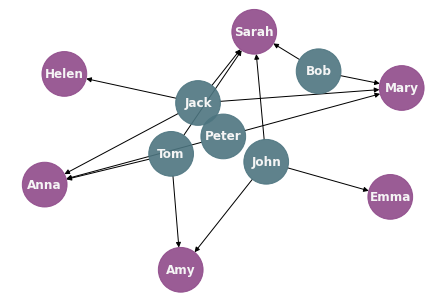

In [85]:
# Remarks: This won't plot node without positive rating associated with it.
# As negative rating has been remove before

import matplotlib.pyplot as plt
import networkx as nx

gr = nx.from_pandas_edgelist(ratings, "UserID", "ProfileID", "Rating", create_using=nx.DiGraph())

mapping = dict(info[["UserID", "Name"]].values.tolist())
color_map = []
for node in gr.nodes():
    if info.loc[info["UserID"] == node, "Gender"].values[0] == "M":
        color_map.append([0.3, 0.46, 0.5, 0.9])
    else:
        color_map.append([0.56, 0.29, 0.54, 0.9])

gr = nx.relabel_nodes(gr, mapping)
pos = nx.fruchterman_reingold_layout(gr)
nx.draw(gr, pos, with_labels=True, node_size=2000, node_color=color_map, font_color="whitesmoke", font_weight="semibold")
plt.show()

## For large dataset visualization

In [99]:
# Only execute this with large dataset

import graph_tool.all as gt 
import random
from IPython.display import Image

network_graph_file = "network-graph-" + str(random.randint(0, 2e9)) + ".png"

g = gt.Graph(directed=True)
vmap = g.add_edge_list(ratings[["UserID", "ProfileID"]].to_numpy(), hashed=True)
pos = gt.fruchterman_reingold_layout(g, n_iter=10)

v_size = g.new_vertex_property("double")
g.vertex_properties["v_size"] = v_size

v_font_size = g.new_vertex_property("double")
g.vertex_properties["v_font_size"] = v_font_size

v_pen_width = g.new_vertex_property("double")
g.vertex_properties["v_pen_width"] = v_pen_width
 
for v in g.vertices():
    v_size[v] = (1 + v.in_degree() * 4) * (1000 / g.num_vertices())
    v_font_size[v] = (1 + v.in_degree()) * (400 / g.num_vertices())
    v_pen_width[v] = (1 + v.in_degree()) * (100 / g.num_vertices())

gt.graph_draw(g, vertex_text=vmap, pos=pos, vertex_size=v_size, vertex_font_size=v_font_size, vertex_fill_color=[0.2, 0.4, 0.53, 0.9], vertex_pen_width=v_pen_width, vertex_font_family="roboto", output_size=(2048, 2048), bg_color=[1, 1, 1, 1], output=network_graph_file)

Image(url=network_graph_file)

# Below are the cells that I haven't finished yet.

In [69]:
# def standardize(row):
#     new_row = (row - row.mean()) / (row.max() - row.min())
#     return new_row

# user_ratings_std = user_ratings.apply(standardize)
# user_ratings_std

In [32]:
# Profile-Profile Similarity with Cosine similarity

def calculate_similarity(data):
    similarity = cosine_similarity(data)
    return similarity

profile_similarity = calculate_similarity(user_ratings.T)
profile_similarity_df = pd.DataFrame(profile_similarity, index=user_ratings_df.columns.values, columns=user_ratings_df.columns.values)
profile_similarity_df

,1,2,5
1,1.000000,0.000000,0.707107
2,0.000000,1.000000,0.707107
5,0.707107,0.707107,1.000000


In [34]:
# Making recommendations

def get_similar_profile(profile_id, user_rating):
    similar_score = profile_similarity_df[profile_id] * user_rating
    similar_score = similar_score.sort_values(ascending=False)
    return similar_score

result = get_similar_profile(1, 1)
result


1    1.000000
5    0.707107
2    0.000000
Name: 1, dtype: float64